<a href="https://colab.research.google.com/github/shivaniprasad22/Pancreatic_cancer_detection/blob/Master/pancreatic_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Classifier,Accuracy,Precision,Recall,F1-score,Detailed Report,Confusion Matrix
0,HistGradientBoostingClassifier,0.882051,0.882867,0.882051,0.881671,"{'0': {'precision': 0.85, 'recall': 0.78461538...","[[51, 14, 0], [9, 63, 0], [0, 0, 58]]"
1,ExtraTreesClassifier,0.861538,0.861480,0.861538,0.861479,"{'0': {'precision': 0.796875, 'recall': 0.7846...","[[51, 14, 0], [13, 59, 0], [0, 0, 58]]"
2,BaggingClassifier,0.835897,0.836302,0.835897,0.835985,"{'0': {'precision': 0.746268656716418, 'recall...","[[50, 15, 0], [17, 55, 0], [0, 0, 58]]"
3,CalibratedClassifierCV,0.835897,0.835897,0.835897,0.835897,"{'0': {'precision': 0.7538461538461538, 'recal...","[[49, 16, 0], [16, 56, 0], [0, 0, 58]]"
4,GaussianProcessClassifier,0.825641,0.826924,0.825641,0.825691,"{'0': {'precision': 0.7540983606557377, 'recal...","[[46, 19, 0], [14, 58, 0], [1, 0, 57]]"


<ipython-input-1-74871c9c98d2>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Classifier', y='Accuracy', data=results_df, palette='muted')


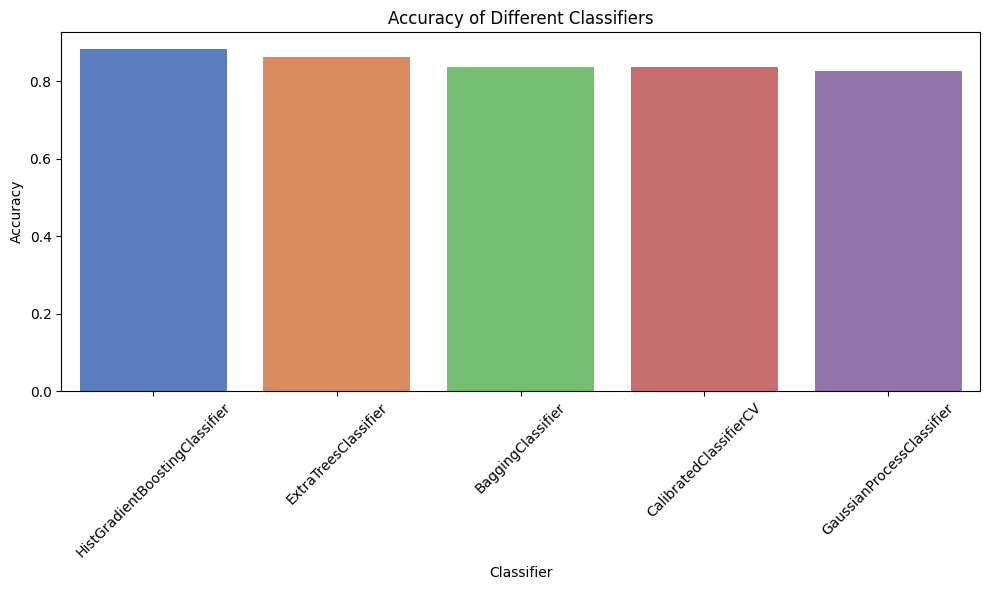

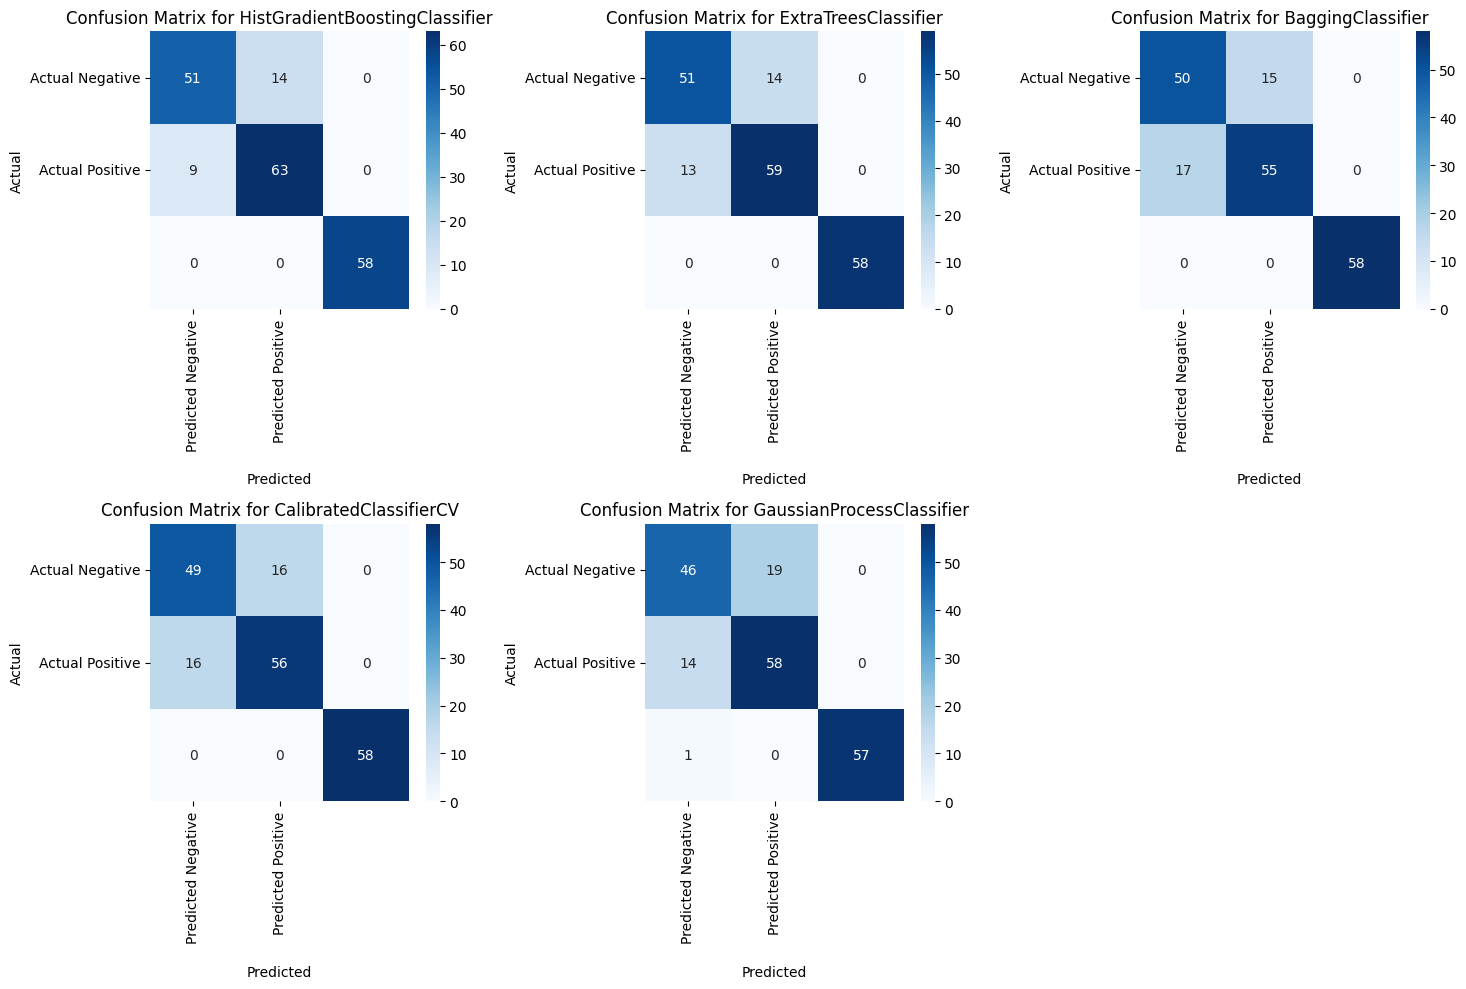

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
from sklearn.utils import all_estimators
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display
from tabulate import tabulate

# Load data
df = pd.read_csv("pancreatic_cancer_data.csv")

# Data Preprocessing
df['stage'] = df['stage'].fillna('0')
df['benign_sample_diagnosis'] = df['benign_sample_diagnosis'].fillna("null")
df['plasma_CA19_9'] = df['plasma_CA19_9'].fillna(df['plasma_CA19_9'].mean())
df['REG1A'] = df['REG1A'].fillna(df['REG1A'].mean())

# Label Encoding
label_encoder = LabelEncoder()
df['sample_origin'] = label_encoder.fit_transform(df['sample_origin'])
df['sex'] = label_encoder.fit_transform(df['sex'])
df['stage'] = label_encoder.fit_transform(df['stage'])
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])
df['benign_sample_diagnosis'] = label_encoder.fit_transform(df['benign_sample_diagnosis'])

# Drop unnecessary columns
df = df.drop(["sample_id", "benign_sample_diagnosis"], axis=1)

# Split data into features and target variable
X = df.drop("diagnosis", axis=1)
y = df['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define which columns should be transformed
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on training data and transform
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Initialize and train the top 5 classifiers
classifiers = [
    ("HistGradientBoostingClassifier", "GradientBoostingClassifier"),
    ("ExtraTreesClassifier", "RandomForestClassifier"),
    ("BaggingClassifier", "AdaBoostClassifier"),
    ("CalibratedClassifierCV", "LinearSVC"),
    ("GaussianProcessClassifier", "LogisticRegression")
]

results = []
conf_matrices = []  # Initialize an empty list to store confusion matrices

for name, class_name in classifiers:
    ClassifierClass = [est[1] for est in all_estimators(type_filter='classifier') if est[0] == class_name]
    if ClassifierClass:
        try:
            classifier = ClassifierClass[0]()
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            report = classification_report(y_test, y_pred, output_dict=True)
            conf_matrix = confusion_matrix(y_test, y_pred)
            results.append([name, accuracy, precision, recall, f1, report, conf_matrix])
            conf_matrices.append(conf_matrix)  # Store confusion matrix
        except Exception as e:
            print(f"Error in {name}: {e}")
    else:
        print(f"No classifier found for {name}")
print("\n\n")

# Create a DataFrame from the results
results_df = pd.DataFrame(
    results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Detailed Report', 'Confusion Matrix']
)

# Display the results DataFrame
display(results_df)
print("\n\n")

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Accuracy', data=results_df, palette='muted')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n\n")

# Plot confusion matrices for all classifiers
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=3, wspace=3)
for i, conf_matrix in enumerate(conf_matrices):
    plt.subplot(2, 3, i+1)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('\nPredicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {results[i][0]}')

plt.tight_layout()
plt.show()

print("\n\n")

# Find the best classifier
best_classifier = results_df.loc[results_df['Accuracy'].idxmax()]
print("\n\n")

# Summary of the best classifier
summary_data = [
    ["Classifier", best_classifier['Classifier']],
    ["Accuracy", f"{best_classifier['Accuracy']:.4f}"],
    ["Precision", f"{best_classifier['Precision']:.4f}"],
    ["Recall", f"{best_classifier['Recall']:.4f}"],
    ["F1-score", f"{best_classifier['F1-score']:.4f}"]
]


print(f"\nBest Classifier: {best_classifier['Classifier']}, Accuracy: {best_classifier['Accuracy']}")
print("\nSummary of the Best Classifier:")
print(tabulate(summary_data, headers=["Metric", "Value"]))


In [ ]:
print("\n")
print("\n")
print("\n")
# Display basic information about original data
print("Original Data Information:")
print(df.info())
print("\n")

# Display basic statistics of numeric columns in original data
print("Summary Statistics of Original Data:")
print(df.describe())
print("\n")

# Display basic information about preprocessed data
print("Preprocessed Data Information:")
print("Shape of preprocessed data:", X_train.shape)
print("\n")


# Display summary statistics of preprocessed data
print("Summary Statistics of Preprocessed Data:")
preprocessed_df = pd.DataFrame(X_train)
print(preprocessed_df.describe())









Original Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_cohort  590 non-null    object 
 1   sample_origin   590 non-null    int64  
 2   age             590 non-null    int64  
 3   sex             590 non-null    int64  
 4   diagnosis       590 non-null    int64  
 5   stage           590 non-null    int64  
 6   plasma_CA19_9   590 non-null    float64
 7   creatinine      590 non-null    float64
 8   LYVE1           590 non-null    float64
 9   REG1B           590 non-null    float64
 10  TFF1            590 non-null    float64
 11  REG1A           590 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 55.4+ KB
None


Summary Statistics of Original Data:
       sample_origin         age         sex   diagnosis       stage  \
count     590.000000  590.000000  590.000000  590.000